In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac
import utilities.chart_kwargs as ck

import utilities.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

# data sources
data_sources = {    
    "survey_data":"results_with_zeroes.csv",
    "river_bassins":"river_basins.json",
    "beaches":"beaches_with_gis.csv",
    "codes":"mlw_codes.csv",
    "code_groups":"code_group2.json",
    "dims_data":"dims_data.csv"
}

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-01-01'
end_date ='2021-04-30'

a_fail_rate = 50
# name of the output folder:
name_of_project = 'bassin_report_aare'

# set the maps
bassin_map = PILImage.open("resources/maps/aare_scaled.jpeg")
# city_map = PILImage.open("resources/maps/biel_scaled.jpeg")


# levels = {"city":"Burgdorf","water_name_slug":'emme', "river_bassin":'aare'}
# levels = {"water_name_slug":'bielersee'}
feature_level = "water_name_slug"
feature_component = "location"
top = "river_bassin"
levels = {feature_component:"location", feature_level:'bielersee', top:'aare'}


level_names = ["Bielersee","Aare survey area"]
# feature_order = [
#     'brienzersee',
#     'thunersee',
#     'neuenburgersee',
#     'bielersee', 
#     'la Thièle', 
#     'schüss',
#     'aare-nidau-buren-kanal',
#     'emme',
#     'aare',    
# ]


# levels = {"city":"Bern","water_name_slug":'aare', "river_bassin":'aare'}
# level_names = ["Linth survey area", "All survey areas"]
# feature_order = [
#     "limmat",
#     "zurichsee",
#     "katzensee",
#     "dorfbach",
#     "sihl", 
#     "Sihlsee",       
#     "jona",
#     "escherkanal",
#     "linthkanal",
#     "walensee",
#     "seez",
# ]

# variables for the directory tree
most_recent, survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

# add the folder to the directory tree:
project_directory = ut.make_project_folder(output, name_of_project)

# keep track of output
files_generated = []
figure_num = 0
data_num = 0

# define the methods to handle the data .JSON or .csv:
my_data_methods = {'json':ut.json_file_get, 'csv':pd.read_csv}

# get your data:
survey_data, river_bassins, dfBeaches, dfCodes, code_groups, dfDims = sut.get_data_from_most_recent(data_sources, data_methods=my_data_methods)

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map locations to feature names
location_wname_key = dfBeaches[feature_component]


# map water_name_slug to water_name
wname_wname = dfBeaches[['water_name_slug','water_name']].reset_index(drop=True).drop_duplicates()
wname_wname.set_index('water_name_slug', inplace=True)


# convenience methods


def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

def get_feature_component(data, feature_level, feature_component):
    return data.loc[data[feature_level] == levels[feature_component]].copy()


def aggregate_a_group_of_codes(data, codes=[], groupby_column="", agg_columns={}):
    
    return data[data.code.isin(codes)].groupby(groupby_column, as_index=False).agg(agg_columns)

def replace_a_group_of_codes_with_one(data, new_code_values=[], codes_to_replace=[]):    
    
    som_data=data[~data.code.isin(codes_to_replace)].copy()
    new_data = pd.concat(new_code_values, ignore_index=True)
    return_data = pd.concat([som_data, new_data], ignore_index=True)
    
    return return_data

def agg_a_group_of_codes_with_one_code(data, new_values, a_list_loc_dates=[], a_model_code=" ", a_new_code=""):
    # aggregate and assign a new code for the values:
    new_df_rows = []
    new_vals = new_values.set_index('loc_date', drop=True)
    for adate in a_list_loc_dates:
        gx = data.loc[(data.loc_date == adate)&(data.code==a_model_code)].copy()        
        gx['code'] = a_new_code
        gx['quantity'] = new_vals.loc[[adate], 'quantity'][0]
        gx['pcs_m'] = new_vals.loc[[adate], 'pcs_m'][0]
        new_df_rows.append(gx)

    # create a data frame with the new values
    new_data = pd.concat(new_df_rows)
    
    return new_data, new_df_rows

def create_aggregate_groups(data, codes_to_agg=[], a_model_code="G79", a_new_code="Gfrags" ):
    
    agretd =  aggregate_a_group_of_codes(data, codes=codes_to_agg, groupby_column='loc_date', agg_columns={'quantity':'sum', 'pcs_m':'sum'})
    loc_dates = agretd.loc_date.unique()
    df, _ = agg_a_group_of_codes_with_one_code(data, agretd, a_list_loc_dates=loc_dates, a_model_code=a_model_code, a_new_code=a_new_code)    
    
    return df
# new column names for display
new_cols = {
    'total_time':'time to survey',
    'length':'meters surveyed',
    'area':'m² surveyed',
    'total_w':'total weight',
    'mac_plast_w':'plastic > 5mm weight',
    'mic_plas_w':'plastic < 5mm weight',
    'num_parts_staff':'staff',
    'num_parts_other':'help',
    'participants':'groups',
    'loc_date':'# samples'
}

# columns to aggregate dimensional data
agg_this = {
    'time to survey':'sum',
    'meters surveyed':'sum',
    'm² surveyed':'sum',
    'total weight':'sum',
    'plastic > 5mm weight':'sum',
    'plastic < 5mm weight':'sum',
    'staff':'sum',
    'help':'sum',
    '# samples':'nunique'
}

def make_a_summary_table(ax, data, cols_to_use, a_color='dodgerblue', font_size=12):
    
    
    ax.auto_set_font_size(False)
    the_cells = ax.get_celld()    
    
    banded_color = colors.to_rgba(a_color)
    banded_color= (*banded_color[:-1], 0.1)
    
    
    # the different areas of formatting
    top_row = [(0,i) for i,x in enumerate(cols_to_use)]
    bottom_row =[(len(data), i) for i,x in enumerate(cols_to_use) ]
    top_columns = top_row[1:]
    data_rows = [x for x in list(the_cells.keys()) if x not in top_row]
    odd_rows = [x for x in data_rows if x[0]%2 > 0]
    first_column = [x for x in data_rows if x[1] == 0]
    
    
    # make the first cell a littel smaller than the others
    ax[0,0].set_height(1/(len(data)))
    ax[0,0].set_text_props(**{'va':'top'})
   
    for a_cell in top_row:
        ax[a_cell].visible_edges = 'B'    
        ax[a_cell].set_text_props(**{'fontsize':font_size})
        ax[a_cell].set_edgecolor('white')
        ax[a_cell].PAD = .1        
       
    for a_cell in top_columns:
        ax[a_cell].set_height((1.25/(len(data))))
        ax[a_cell].set_text_props(**{'va':'bottom'})
        ax[a_cell].set_edgecolor(banded_color)
        ax[a_cell].visible_edges = 'T'    
    
    for a_cell in odd_rows:
        ax[a_cell].set_facecolor( banded_color)
    
    for a_cell in data_rows:
        ax[a_cell].set_height(.75/(len(data)))
        ax[a_cell].visible_edges = 'BTLR' 
        ax[a_cell].set_text_props(**{'fontsize':font_size})
        ax[a_cell].set_edgecolor('white')
        
    for a_cell in first_column:
        ax[a_cell]._text.set_horizontalalignment('right')
        ax[a_cell].PAD = .02
        
    for a_cell in bottom_row:
        ax[a_cell].visible_edges = 'B'
        ax[a_cell].set_edgecolor(banded_color) 
        
        
    return ax

def add_a_new_code(a_name, a_model, a_dict_params, code_df):
    
    for param in a_dict_params:
        a_model[param] = a_dict_params[param]
    
    code_df.loc[a_name] = a_model
    
    return code_df
def shorten_the_value(an_array,a_df):
    a_df.loc[an_array[0], an_array[1]] = an_array[2]
    return a_df
# set the index of dfCodes to code:
dfCodes.set_index('code', inplace=True)

# Create new codes to aggregate the EPS pieces and the Plastic pieces
a_name = 'Gfrags'
a_model = dfCodes.loc['G79'].copy()
a_dict_params = {'description':'Fragmented plastics'}

dfCodes = add_a_new_code(a_name, a_model, a_dict_params, dfCodes)

a_name = 'Gfoam'
a_model = dfCodes.loc['G82'].copy()
a_dict_params = {'description':'Expanded polystyrene'}

dfCodes = add_a_new_code(a_name, a_model, a_dict_params, dfCodes)

# these descriptions need to be shortened for display
dfCodes = shorten_the_value(["G74", "description", "Insulation: includes spray foams and foam board"], dfCodes)
dfCodes = shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = shorten_the_value(["G96", "description", "Sanitary-pads/panty liners/tampons"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material


<a id='top'></a>
## Identification, quantification and analysis of observable anthropogenic debris along swiss river and lakes (IQASL)


IQASL is a project sponosored by the Swiss Federal Office for the environment to quantify shoreline trash along swiss lakes and rivers in the Rhone, Aare, Ticino and Linth/Limmat catchment areas. This is accomplished by conducting multiple small scale and discrete **litter surveys** throughout the river bassin. The majority of samples are taken from lakes.

**What is a litter survey?**

A litter survey is the **identification and count of all objects found within a delimited area**, in this study all surveys were bordered on one side by water. Each object is placed into one of 260 categories¹. The location, date, survey dimensions and the total number of objects in each category is noted.

**Purpose of the surveys**

The survey results help ALL stakeholders identify the items that make up the mass of trash found in the natural environment on the shores of Swiss lakes and rivers. The surveys answer the following questions:

*  What items are found?
*  How much is found ? (total weights and item counts)
*  How often are these items found?
*  Where do you find the most?

These are the most frequently asked questions and should be considered when determining any mitigation or reduction strategies.

The project is based on the following assumptions:

*  The more trash there is on the ground the more a person is likely to find
*  The survey results represent the minimum amount of trash at that site²
*  For each survey: finding one item does not effect the chance of finding another³

**Purpose of this report**

Summarize the results for the survey area and define the magnitude of those results with respect to other survey areas. 

**The survey results are presented as follows:**

* Total object count, total weight and weight of plastics
* The most abundant objects from the survey area and all the other survey areas sorted by total object count 
* Pieces of trash per meter (pcs/m): the ratio of number of objects found to the length of the shoreline
* Objects that were found in at least 50% of the surveys

**Contents of this report**

[Scope: description of river basin](#scope)
  * survey locations
  * lakes and rivers
  * municipalities and effected population
   
[Survey dimensions, locations, aggregated totals](#aggregatedtotals)
  * weights and measures: cumulative
  * weights and measures: cumulative by water feature
  * survey totals: pcs/m by date
  * material type: % of total
   
[Trash removed: most abundant objects](#combinedtopten)
  * the most common objects from the survey area
  * the most common objects from all the survey areas
  * pcs/m of most common objects for all water features in the survey area
   
[Trash removed the most often](#frequency)
  * objects that are found in more than 50% of surveys
  * objects that are the most abundant
  * objects found in less than 50% of the surveys
   
[Trash removed: utility](#matanduse)
  * utility classification: % total of all objects found

[Annex](#annex)
  * effective data: report of missing records
  * survey location coordinates
  * population profile and results by municipality
  * itemized list of objects removed


**More information**

For more information about the project visit [project home](https://www.plagespropres.ch/).

If you would like more information specific information about this survey area please contact:

1. Swiss federal office for the environment - Municipal waste section
2. analyst@hammerdirt.ch

¹ [The EU guide on monitoring marine litter](https://mcc.jrc.ec.europa.eu/documents/201702074014.pdf)<br> ² There is most likely more trash at the survey site, but certainly not less than what was recorded.<br>³ Independent observations : [stats stackexchange](https://stats.stackexchange.com/questions/116355/what-does-independent-observations-mean)

In [2]:
md(F"## Results: {level_names[0]}")

## Results: Bielersee

### Scope

The Aare source is the Aare Glaciers in the Bernese Alps of south-central Switzerland. The Aare is the longest river entirely within Switzerland with a length of 295 km and drainage area of 17,779 km2. Following the Aare Gorge, the river expands into the glacial Lake Brienz. The Aare is canalized at Interlaken before entering Lake Thun and exiting through the city of Thun.⁵ The river then flows northwest surrounding the old city center of Bern on three sides. Continuing west to Lake Wohlen Reservoir it turns north to Aarberg and is diverted west into Lake Biel by the Hagneck Canal, one of a series of major water corrections made in the 19th and 20th centuries connecting Neuchatel, Biel and Morat lakes through canalization. From the upper end of Lake Biel, at Nidau, the river exits through the Nidau-Büren Canal/Aare Canal.⁶

The Limmat and Reuss rivers⁷, two major tributaries converge into the Aare at the Limmatspitz between the cities of Brugg and Untersiggenthal in Canton Aargau.⁸ The Aare river ends in the north-western region of Koblenz, Switzerland where it joins the Rhine river which eventually terminates in the North Sea.

<span style="font-size:10px">⁵ The Editors of Encyclopaedia Britannica. (1998, July 20). Aare River. Retrieved from Britannica.com: https://www.britannica.com/place/Aare-River 
<br>⁶ Standard Encyclopedia of Worlds Rivers and Lakes. (1965) R.K. Gresswell
<br>⁷ The Limmat and Reuss are part of different survey areas
<br>⁸ Pro Natura . (n.d.). Limmatspitz. Retrieved from Pro Natura : https://www.pronatura-ag.ch/de/Gebenstorf-limmatspitz</span>


#### Survey locations, municipalities


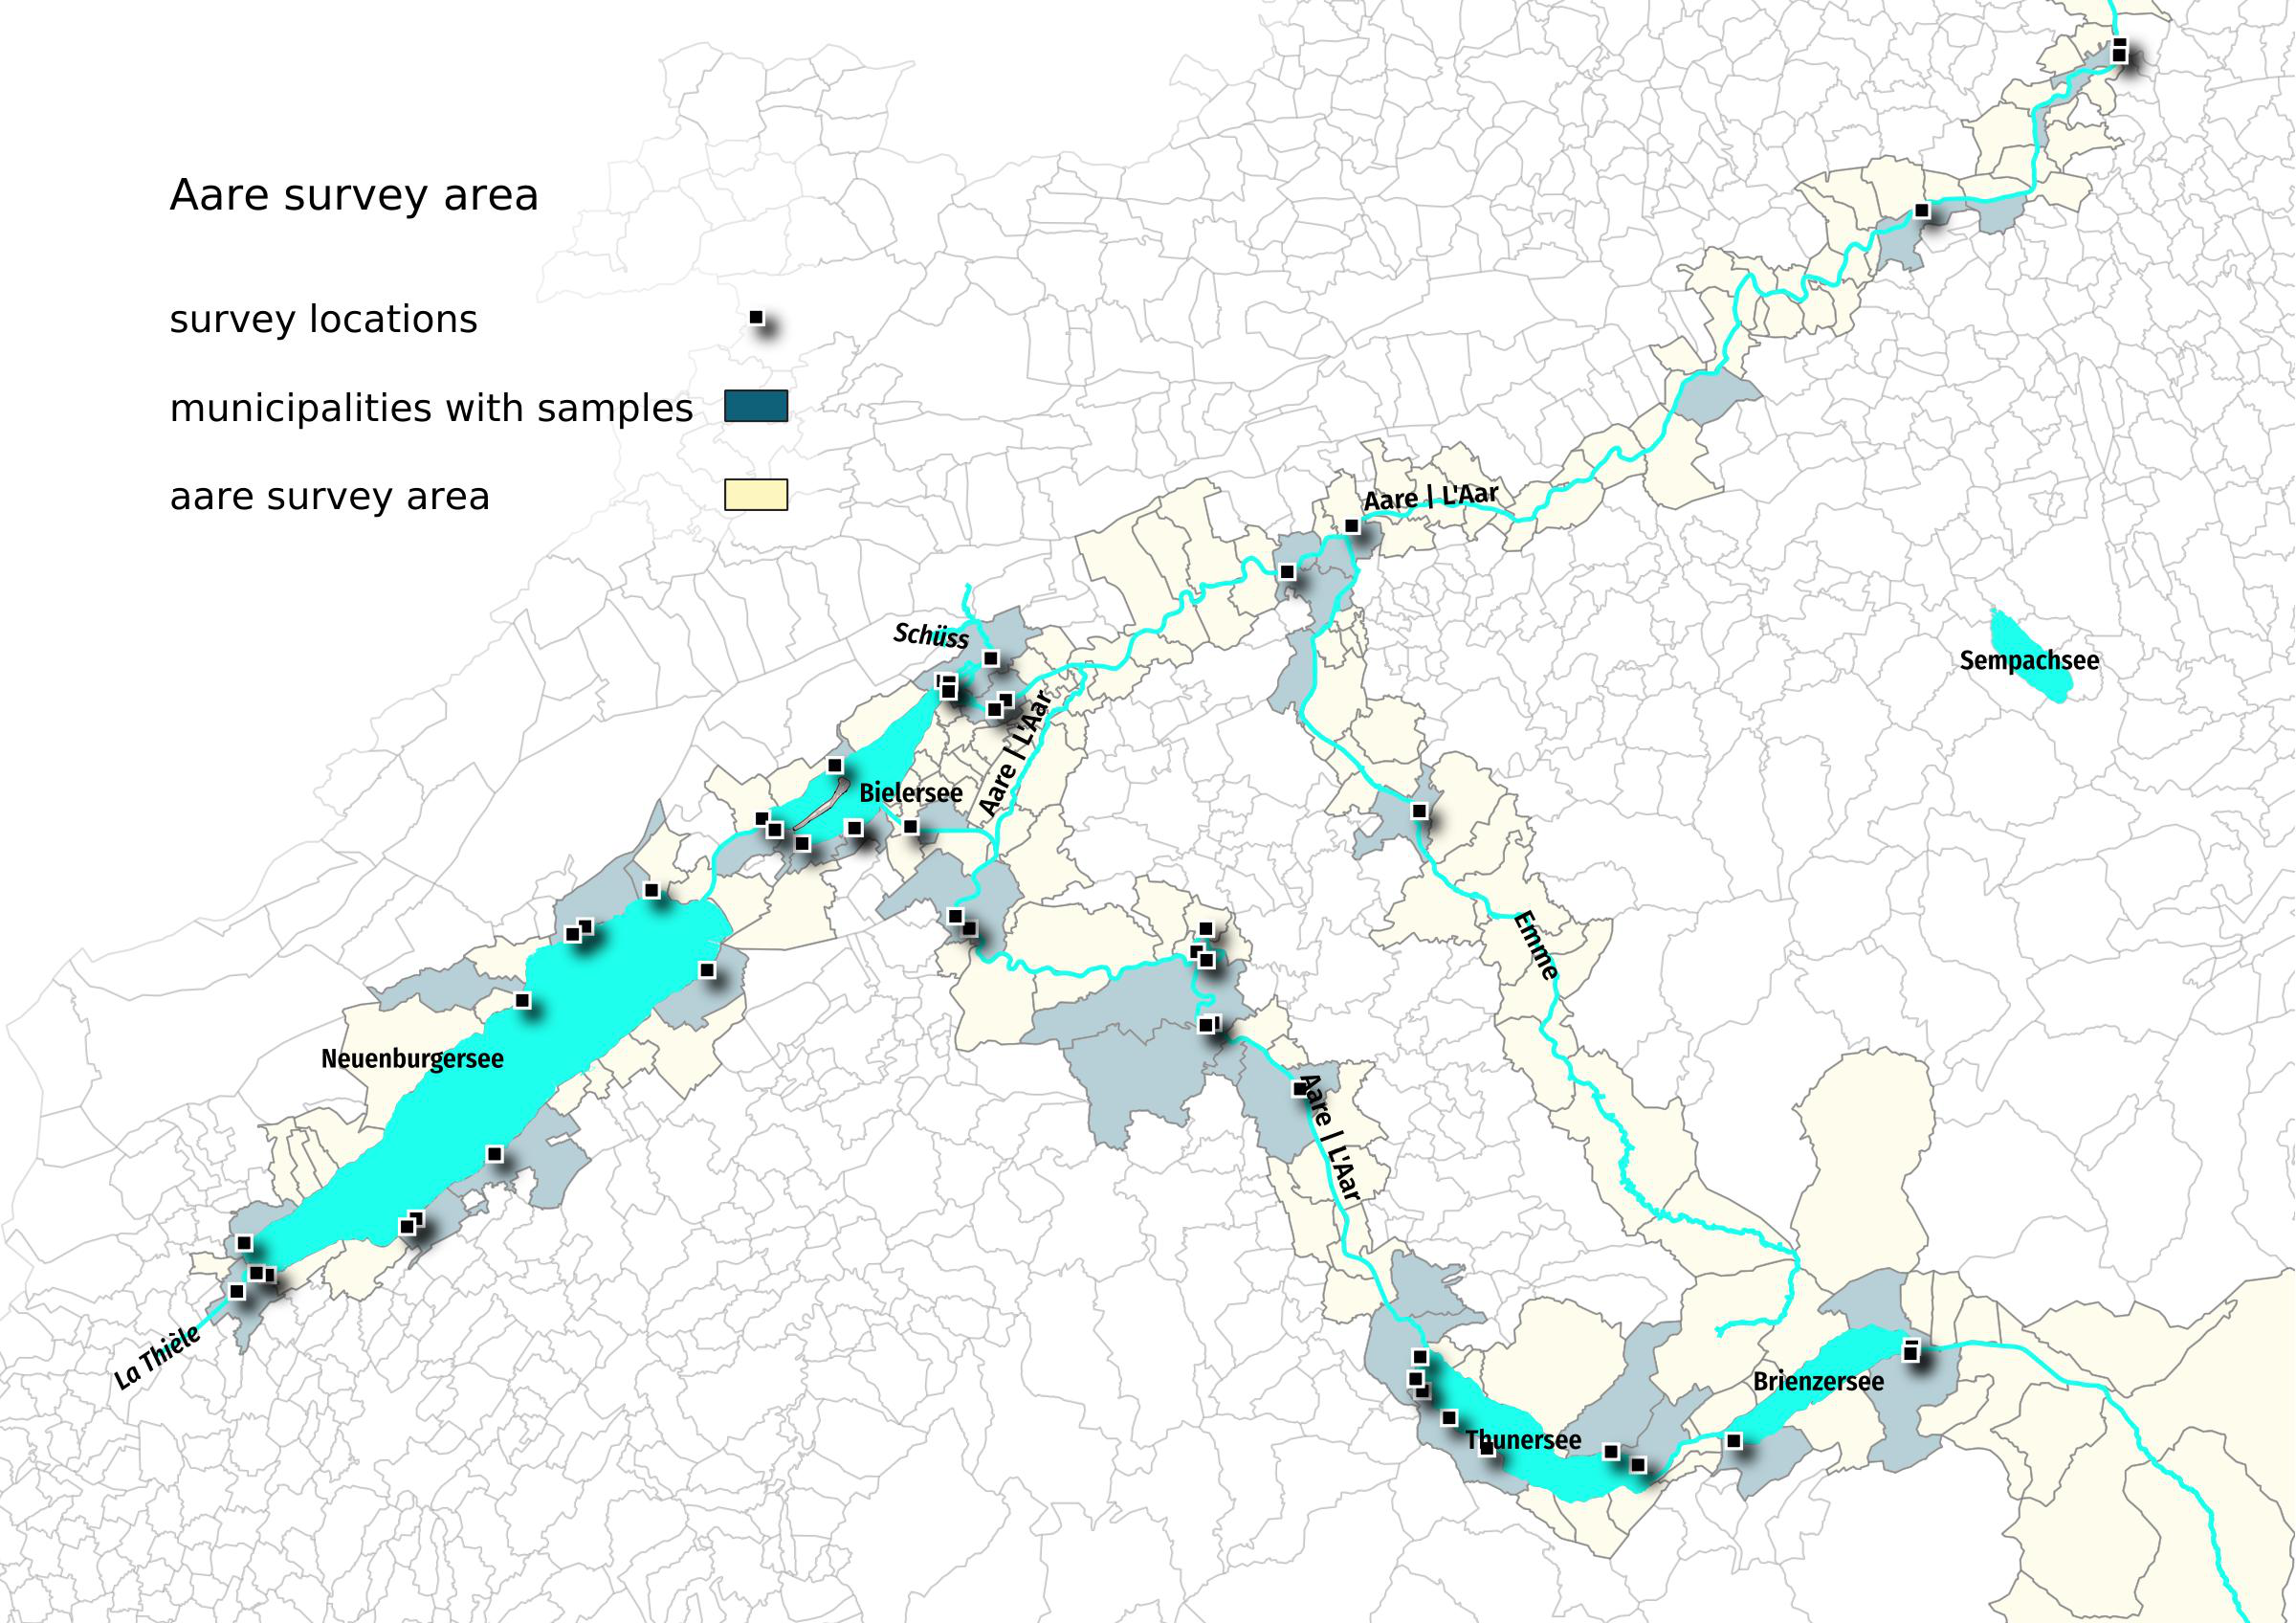

In [3]:
output = io.BytesIO()
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

In [4]:
# format the date to timestamp and slice the data by start/end date
dfSurveys = sut.fo_rmat_and_slice_date(survey_data.copy(), a_format="%Y-%m-%d", start_date=start_date, end_date=end_date)

siblings = river_bassins[levels[top]]


# add the grouping column defined by river_bassins
data = sut.add_a_grouping_column(dfSurveys, river_bassins, column_to_match="water_name_slug")
# data = data.loc[data.river_bassin == levels[top]]

# put the data into a class
# kwargs for the abundance class
a_class_kwargs = dict(
    code_group_data=code_groups,
    levels=['river_bassin', 'water_name_slug', 'city'],
    river_bassins=river_bassins,
    exp_variables=['population','buildings', 'streets', 'intersects'],       
    code_group_loc=output,    
)

# the data labled by river bassin, water feature, city and beach name with independent variables attached
a = sut.SurveyData(data, dfBeaches, these_cols=['loc_date', 'location', 'water_name_slug','date'], **a_class_kwargs)

# define the final data set here:
a_data = a.survey_data.copy()

# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
some_foams = ['G81', 'G82', 'G83']

# the codes for the fragmented plastics
some_frag_plas = list(a_data[a_data.groupname == 'plastic pieces'].code.unique())
    
the_plast_rows = create_aggregate_groups(a_data, codes_to_agg=some_frag_plas,a_model_code="G79", a_new_code="Gfrags")
the_foam_rows = create_aggregate_groups(a_data, codes_to_agg=some_foams, a_model_code="G82", a_new_code="Gfoam")

# the foam codes and fragmented plastic codes have been aggregated in to Gfrags and Gfoam
new_som_data = replace_a_group_of_codes_with_one(a_data, new_code_values=[the_plast_rows, the_foam_rows], codes_to_replace=[*some_frag_plas, *some_foams])

# keep the orginal data to test on
before_agg = a_data.copy()

# replace a_data with new new_som_data
a_data = new_som_data.copy()

# identify all records with a quantity > 0
a_data['fail'] = a_data.quantity > 0

# map material to a_data
a_data['material'] = a_data.code.map(lambda x: code_material_map[x])

# get the material totals
material_totals = a_data.groupby('material').quantity.sum()

code_totals_all_data = a_data.groupby('code', as_index=False).quantity.sum()

# all data top ten
ct_all_data = code_totals_all_data[['code','quantity']].sort_values(by='quantity', ascending=False)

# percent of total
ct_all_data["% of total"] = ct_all_data.quantity/ct_all_data.quantity.sum()
ct_all_data.set_index('code', inplace=True)
ct_all_data['material'] = ct_all_data.index.map(lambda x: code_material_map[x])
dt_all = a_data.groupby(['loc_date', 'date'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})

top_feature_data = a_data[a_data[top] == levels[top]].copy()
tp_feat_dt = top_feature_data.groupby(['loc_date', 'date'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
fail_rates_top = ac.agg_fail_rate_by_city_feature_basin_all(top_feature_data, levels, group='code')
tp_ct = top_feature_data.groupby("code", as_index=False).quantity.sum()
tp_ct["% of total"] = tp_ct.quantity/tp_ct.quantity.sum()
tp_ct.set_index('code', inplace=True)

In [5]:
# define the data set for the feature level:
fd = a_data.loc[a_data[feature_level] == levels[feature_level]].copy()

# get the unique loc_date values:
fd_samps = list(fd.loc_date.unique())

# get the fail rates for the feature level
# fail_rates_fd = ac.agg_fail_rate_by_city_feature_basin_all(a_data, levels, group='code')

# gather the survey location names:
fd_locs = list(fd.location.unique())

# gather the feature component names and types for the basin
fc_names = list(fd[feature_component].unique())
# feature_type_map = dfBeaches.loc[dfBeaches.water_name_slug.isin(fc_names)][[feature_component, 'water']].drop_duplicates().set_index(feature_component, drop=True)

# rb_rivers = list(feature_type_map.loc[feature_type_map.water == 'r'].index)
# rb_lakes = list(feature_type_map.loc[feature_type_map.water == 'l'].index)
# rb_component_features = trb[feature_component].unique()

# gather the municpalities and the population:
fd_munis = list(fd.city.unique())
fd_pop_map=fd.loc[fd.city.isin(fd_munis)][['city', 'population']].drop_duplicates().set_index('city', drop=True)

# survey_totals river bassin
fd_dt=fd.groupby(['loc_date', 'date',feature_component], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})

# map survey total quantity to loc_date
fd_dq = fd_dt[['loc_date', 'quantity']].set_index('loc_date')

# map utility to code
utility_map = fd[['code', 'groupname']].drop_duplicates().set_index('code', drop=True)

# code totals for the river bassin
fd_code_t= fd.groupby('code', as_index=False).quantity.sum()

# river bassin top ten
fd_t_ten = fd[['code','quantity']].sort_values(by='quantity', ascending=False)

# combined top ten all data and river bassin data
a_combined_t_ten = [*ct_all_data.index[:10],*fd_t_ten['code'][:10]]

# percent of total
fd_code_t["% of total"] = fd_code_t.quantity/fd_code_t.quantity.sum()
fd_code_t.set_index('code', inplace=True)
fd_code_t['material'] = fd_code_t.index.map(lambda x: code_material_map[x])

# material totals:
fd_mat_t = fd_code_t[['material', 'quantity']].groupby('material', as_index=False).quantity.sum()
fd_mat_t["% of total"] = fd_mat_t.quantity/fd_mat_t.quantity.sum()


# map the number of samples per feature component
fd_samples_feature = fd.groupby(feature_component).loc_date.nunique()

# map total quantity per feature_component:
qty_all_features = fd.groupby(feature_component).quantity.sum()
qty_feature = {location_wname_key[x]:qty_all_features[x] for x in qty_all_features.index}

# get groupname totals
fd_group_totals = fd[fd.quantity > 0].groupby(['loc_date','groupname'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
fd_group_totals = fd.groupby(['groupname']).agg({'pcs_m':'median', 'quantity':'sum'})

# summary statistics:
fd_n_samps = len(fd_samps)
fd_n_obj = fd.quantity.sum()
fd_n_locs = len(fd_locs)
fd_n_munis = len(fd_munis)
fd_effected_population = fd_pop_map.sum()

In [6]:
# gather the dimensional data for the time frame from dfDims


fd_dims= dfDims[(dfDims.location.isin(fd_locs))&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# make a loc_date column and get the unique values
fd_dims['loc_date'] = list(zip(fd_dims.location, fd_dims.date))
dim_samps = list(fd_dims.loc_date.unique())

# use only data from the surveys in trb:
# som_dims = fd_dims[fd_dims.loc_date.isin(fd_samps)].copy()

# map quantity per survey to the dims data
fd_dims['quantity'] = fd_dims.loc_date.map(lambda x: ut.use_this_key(x,fd_dq, column='quantity'))

# keep the dims that did not get tagged with a qty
no_qty = fd_dims[fd_dims.quantity == 'no data']

# drop the dims that did not match
som_dims = fd_dims[fd_dims.quantity != 'no data'].copy()

# identify the surveys with no matching dimensional data
no_matching_dim_records = [x for x in list(fd_samps) if x not in list(dim_samps)]

obj_string = '{:,}'.format(fd_n_obj)
surv_string = '{:,}'.format(fd_n_samps)
pop_string = '{:,}'.format(fd_effected_population[0])

In [7]:
date_quantity_context = F"For the period between {start_date[:-3]} and {end_date[:-3]}, {obj_string } objects were removed and identified in the course of {surv_string} surveys."
geo_context = F"Those surveys were conducted at {fd_n_locs} different locations."
admin_context = F"There are {fd_n_munis} different municipalities represented in these results with a combined population of approximately {pop_string}"
md(F"{date_quantity_context} {geo_context } {admin_context}")

For the period between 2020-01 and 2021-04, 4,618 objects were removed and identified in the course of 38 surveys. Those surveys were conducted at 9 different locations. There are 7 different municipalities represented in these results with a combined population of approximately 69,425.0

In [8]:
munis_joined = ', '.join(sorted(fd_munis))

muni_string = F"""**The municipalities in this report:**\n\n{munis_joined}
"""
md(muni_string)

**The municipalities in this report:**

Biel/Bienne, Gals, Le Landeron, Ligerz, Lüscherz, Nidau, Vinelz


In [9]:
# assign a water feature name to each record
som_dims[feature_component] = som_dims.location.map(lambda x: location_wname_key.loc[x])

# 90-120 minutes covers some of the travel, equipment preparation and maintenance and incidental time on location:
som_dims['total_time'] = ((som_dims.time_minutes+90)/60).round(2)

# rename the columns for display and export:
som_dims.rename(columns=new_cols, inplace=True)

In [10]:
dims_summary_stats = som_dims.groupby(feature_component).agg(agg_this)

# convert the plastic weights to kilos
dims_summary_stats['plastic > 5mm weight'] = dims_summary_stats['plastic > 5mm weight']/1000
dims_summary_stats['plastic < 5mm weight'] = dims_summary_stats['plastic < 5mm weight']/1000

# labor hours = (staff+help/number of samples)*time_to_survey
dims_summary_stats['labor hours'] = ((dims_summary_stats.staff + dims_summary_stats.help)/dims_summary_stats["# samples"])*dims_summary_stats['time to survey']
dims_summary_stats['labor hours'] = dims_summary_stats.astype('int')

# get the quantity found per water feature
dims_summary_stats['pieces of trash'] = dims_summary_stats.index.map(lambda x: ut.use_this_key(x, qty_feature))

In [11]:
dims_summary_stats

,time to survey,meters surveyed,m² surveyed,total weight,plastic > 5mm weight,plastic < 5mm weight,staff,help,# samples,labor hours,pieces of trash
location,,,,,,,,,,,
Bielersee_Vinelz_FankhauserS,39.67,238,536.0,3.099,1.864,0.000840,12,0,12,39,898
Camp des pêches,3.33,37,93.0,0.045,0.035,0.000000,1,0,1,3,53
Gals reserve,5.00,38,64.0,0.430,0.405,0.000001,2,0,2,5,48
Ligerz strand,5.67,15,49.0,0.295,0.294,0.000000,2,0,2,5,143
Lüscherz plage,9.91,236,517.0,1.570,0.232,0.000030,4,0,4,9,194
Lüscherz two,2.25,21,21.0,0.148,0.100,0.000000,1,0,1,2,8
Müllermatte,59.33,512,4291.0,5.588,3.348,0.001819,14,1,13,59,2964
Nidau strand,3.17,25,105.0,0.130,0.002,0.000236,1,0,1,3,63
Strandboden-Biel,7.15,93,420.0,2.250,0.440,0.000172,2,0,2,7,247


[top](#top)<a id="aggregatedtotals"></a>
### Survey  dimensions, location and aggregated totals.

In [12]:
# these columns should be ints
ints =  [
    'meters surveyed',
    'm² surveyed',
    'total weight',
    '# samples',
    'pieces of trash'
]

# columns to aggregate
col_order = ['# samples', 'pieces of trash',  'meters surveyed', 'm² surveyed', 'total weight', 'plastic > 5mm weight','plastic < 5mm weight', 'labor hours']

# aggregate the water feature frame
dims_stats = dims_summary_stats[col_order].sum().round(2)
dims_stats['# samples'] = len(som_dims)

# make a df for display or export
asum = pd.DataFrame(dims_stats).reset_index()
asum['summary total'] = level_names[0]
asum = asum.pivot(columns='index', values=0, index='summary total')
asum[ints] = asum[ints].applymap(lambda x: '{:,}'.format(int(x)))
asum = asum[col_order]
# asum_display = pd.DataFrame(asum.)

cum_results = F"#### Cumulative totals all data\nThe cumulative results from {fd_n_samps} samples, weights are in kilograms, time is in hours"
md(cum_results)

#### Cumulative totals all data
The cumulative results from 38 samples, weights are in kilograms, time is in hours

In [13]:
asum

index,# samples,pieces of trash,meters surveyed,m² surveyed,total weight,plastic > 5mm weight,plastic < 5mm weight,labor hours
summary total,,,,,,,,
Bielersee,38,"4,618","1,215","6,096",13,6.72,0.0,132.0


#### Cumulative totals by water feature

In [14]:
dims_summary_stats_display = dims_summary_stats.copy()
dims_summary_stats_display[ints] = dims_summary_stats_display[ints].applymap(lambda x: '{:,}'.format(int(x)))
dims_summary_stats_display[col_order]

,# samples,pieces of trash,meters surveyed,m² surveyed,total weight,plastic > 5mm weight,plastic < 5mm weight,labor hours
location,,,,,,,,
Bielersee_Vinelz_FankhauserS,12,898,238,536,3,1.864,0.000840,39
Camp des pêches,1,53,37,93,0,0.035,0.000000,3
Gals reserve,2,48,38,64,0,0.405,0.000001,5
Ligerz strand,2,143,15,49,0,0.294,0.000000,5
Lüscherz plage,4,194,236,517,1,0.232,0.000030,9
Lüscherz two,1,8,21,21,0,0.100,0.000000,2
Müllermatte,13,"2,964",512,"4,291",5,3.348,0.001819,59
Nidau strand,1,63,25,105,0,0.002,0.000236,3
Strandboden-Biel,2,247,93,420,2,0.440,0.000172,7


#### Survey totals pieces per meter, material type % of total

In [15]:
# the monthly average
tp_feat_dt['month'] = tp_feat_dt.date.dt.month
dts_date = tp_feat_dt.set_index('date')
monthly_plot = dts_date.pcs_m.resample('M').median()

# material totals
fd_mat_totals = fd_mat_t.sort_values(by='quantity', ascending=False)

cols_to_use = {'material':'Item','quantity':'Quantity', '% of total':'% of total'}
fd_mat_totals['% of total'] =(fd_mat_totals['% of total']*100).round(1)
fd_mat_totals['quantity']=fd_mat_totals.quantity.map(lambda x: '{:,}'.format(x))
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values

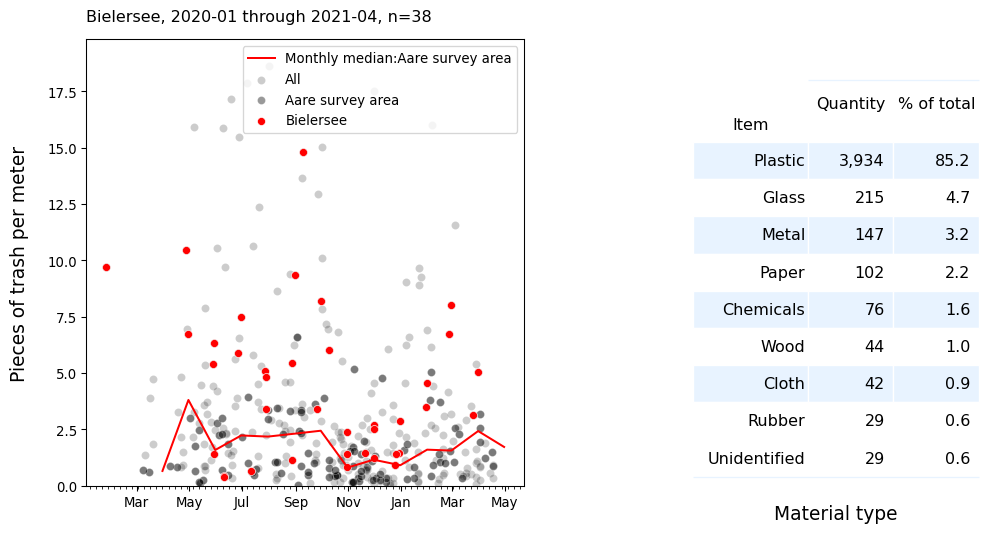

In [16]:
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)

fig = plt.figure(figsize=(12,6), dpi=96)
gs = GridSpec(1, 12, figure=fig, wspace=.3, hspace=.3, top=.9)

axone = fig.add_subplot(gs[:, :6])
axtwo = fig.add_subplot(gs[:, 8:12])

for spine in axtwo.spines.values():
    spine.set_visible(False)
axtwo.tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)
axtwo.set_xlabel("Material type", **ck.xlab_k14)

sns.scatterplot(data=dt_all, x='date', y='pcs_m', color='black', alpha=0.2, label="All", ax=axone)
sns.scatterplot(data=tp_feat_dt, x='date', y='pcs_m', color='black', alpha=0.4, label=level_names[1], ax=axone)
sns.lineplot(data=monthly_plot, x=monthly_plot.index, y=monthly_plot, color='red', label=F"Monthly median:{level_names[1]}", ax=axone)
sns.scatterplot(data=fd_dt, x='date', y='pcs_m', color='red', label=level_names[0], ax=axone)

axone.set_xlabel("")
axone.set_ylabel("Pieces of trash per meter", **ck.xlab_k14)
axone.set_title(F"{level_names[0]}, {start_date[:7]} through {end_date[:7]}, n={fd_n_samps}",  **ck.title_k)
axone.xaxis.set_minor_locator(days)
axone.xaxis.set_major_formatter(months_fmt)
axone.set_ylim(0,fd_dt.pcs_m.max()+5)

a_table = axtwo.table(cellText=fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .3,.3], loc='lower center')
the_material_table_data = make_a_summary_table(a_table,fd_mat_totals,list(cols_to_use.values()))

plt.show()
plt.close()

[top](#top)<a id='combinedtopten'></a>
### The top ten most abundant items

In [17]:
# survey area top ten
rbt = fd_code_t.sort_values(by='quantity', ascending=False)[:10].copy()
rbt['item'] = rbt.index.map(lambda x: code_description_map.loc[x])

rbt['% of total'] =(rbt['% of total']*100).round(1)

rb_t_ten_total = rbt.quantity.sum()
rb_t_ten_ptotal = rb_t_ten_total/fd_code_t.quantity.sum()

rbt['quantity'] = rbt.quantity.map(lambda x: '{:,}'.format(x))


# all survey areas top ten
adt = ct_all_data.sort_values(by='quantity', ascending=False)[:10].copy()
adt['item'] = adt.index.map(lambda x: code_description_map.loc[x])

adt['% of total'] =(adt['% of total']*100).round(1)

ad_t_ten_total = adt.quantity.sum()
ad_t_ten_ptotal = ad_t_ten_total/ct_all_data.quantity.sum()

adt['quantity'] = adt.quantity.map(lambda x: '{:,}'.format(x))

cols_to_use = {'item':'Item','quantity':'Quantity', '% of total':'% of total'}
all_survey_areas = adt[cols_to_use.keys()].values
rb_t_ten_d = rbt[cols_to_use.keys()].values

shared_objects = list(set(rbt.item) & set(adt.item))

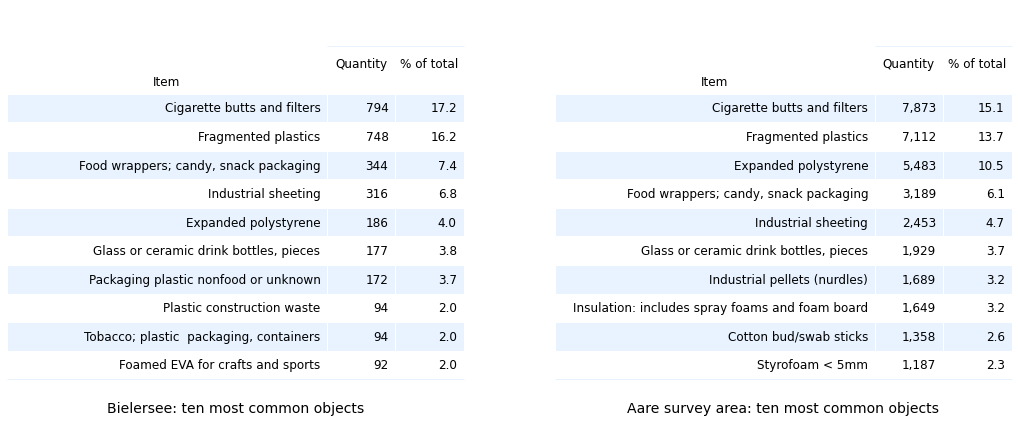

In [18]:
width = 18
a_color='dodgerblue'

fig, axs = plt.subplots(1,2, figsize=(width,len(rb_t_ten_d)*.7))

for spine in axs[0].spines.values():
    spine.set_visible(False)
axs[0].tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)
axs[0].set_xlabel(F"{level_names[0]}: ten most common objects", **ck.xlab_k14)

for spine in axs[1].spines.values():
    spine.set_visible(False)
axs[1].tick_params(bottom=False, labelbottom=False,
               left=False, labelleft=False)
axs[1].set_xlabel(F"{level_names[1]}: ten most common objects", **ck.xlab_k14)

the_first_table_data = axs[0].table(rb_t_ten_d,  colLabels=list(cols_to_use.values()), colWidths=[.7, .15,.15],loc='lower center')
the_second_table_data = axs[1].table(all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.7, .15,.15],loc='lower center')

a_summary_table_one = make_a_summary_table(the_first_table_data,rbt,list(cols_to_use.values()), a_color)
a_summary_table_two = make_a_summary_table(the_second_table_data,adt,list(cols_to_use.values()), a_color)


plt.show()
plt.tight_layout()
plt.close()

In [19]:
rb_string = F"Combined, the ten most abundant objects of the {level_names[0]} represent {int(rb_t_ten_ptotal*100)}% of all objects found in the survey area."
ad_string = F"Of the most abundant objects in the {level_names[0]}, {len(shared_objects)} are also among the most abundant when all the survey areas are combined."
the_shared_objects = [F"{i+1}. {x}" for i,x in enumerate(shared_objects)]
tso_string = '\n'.join(the_shared_objects)
md(F"{rb_string } {ad_string }\n{tso_string}")

Combined, the ten most abundant objects of the Bielersee represent 65% of all objects found in the survey area. Of the most abundant objects in the Bielersee, 6 are also among the most abundant when all the survey areas are combined.
1. Fragmented plastics
2. Industrial sheeting
3. Cigarette butts and filters
4. Glass or ceramic drink bottles, pieces
5. Food wrappers; candy, snack packaging
6. Expanded polystyrene


#### The most abundant objects: results by water feature

Some objects are found throughout the survey area and some of those objects are found in all survey areas. Knowing which objects are most abundant and what those values are helps idenitify sources or zones of accumulation. 

In [20]:
# the feature component
feature_names = [x for x in fc_names]

# the names/labels to search with:
column_names = [*feature_names, levels[feature_level]]

j={"name":"value"}
fc_names_dict = {levels[feature_component]:[x for x in fc_names]}
feature_name_dict = {feature_level:[levels[feature_level]]}
feature_top = {top:[levels[top]]}

features_and_levels = {**fc_names_dict, **feature_name_dict, **feature_top}


# the names labels to display
names_for_cols = [*feature_names,*level_names]
# names_for_cols.append(level_names[0])

#kwargs for aggregator
these_kwargs = dict(
    group='code',
    dailycols={'pcs_m':'sum', 'quantity':'sum'}, 
    agg_cols={"pcs_m":"mean"},
    national=True,
    col_name="All survey areas",
    level_names=names_for_cols,
    bassin_summary=True,
    daily=True,
    feature_component=feature_component,
    feature_level=feature_level
)

t_ten_all_data = ac.agg_pcs_m_by_city_feature_basin_all(a_data[(a_data.code.isin(a_combined_t_ten))], features_and_levels, **these_kwargs)

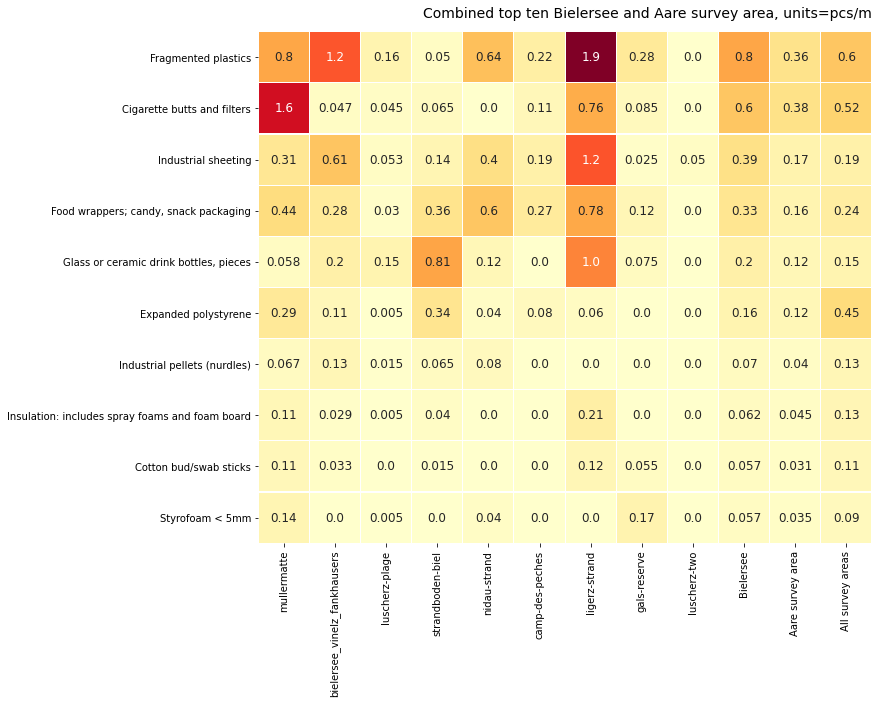

In [21]:
t_ten_all_data['item'] = t_ten_all_data.index.map(lambda x: code_description_map[x])
ad_t_ten = t_ten_all_data.set_index('item', drop=True)
ad_t_ten.sort_values(by=level_names[0], ascending=False, inplace=True)

# chart that
fig = plt.figure(figsize=(11,11))
gs = GridSpec(12, 3, figure=fig,  width_ratios=[.45,.1,.45])

axone = fig.add_subplot(gs[:, :])

sns.heatmap(ad_t_ten, ax=axone, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12}, fmt='.2',  square=True, cbar=False, linewidth=.1, linecolor='white')
axone.set_title(F"Combined top ten {level_names[-2]} and {level_names[-1]}, units=pcs/m", **ck.title_k14r)
axone.set_ylabel("")

plt.setp(axone.get_xticklabels(), rotation=90)

plt.show()
plt.close()

[top](#top)<a id='frequency'></a>
### How often are these objects found?

Some objects are found often and in elevated quantities, others are found often and in small quantities and some times objects are found less often but in large quantities. Knowing the diffference can help find the sources.


In [22]:
fail_rates_df = ac.agg_fail_rate_by_city_feature_basin_all(a_data, {feature_level:levels[feature_level]}, group='code')


In [23]:
# this is a convenience function for the abundance class
# the fail rate needs to be recalculated at each aggregation level
# fail_rates_df = ac.agg_fail_rate_by_city_feature_basin_all(a_data, {'river_bassin':levels['river_bassin']}, group='code')

d = fail_rates_df[(fail_rates_df.iloc[:, :] >= (a_fail_rate/100)).any(axis=1)]


In [24]:


# get the fail rates of the combined top ten >= a_fail_rate
first_level_fail = d.loc[d.index.isin(a_combined_t_ten)][levels[feature_level]].sort_values(ascending=False).index


In [25]:
objs_both = first_level_fail
objs_fail_not_t_ten = list(set(a_combined_t_ten)-set(first_level_fail))
objs_not = [x for x in d.index if x not in a_combined_t_ten]

In [26]:
pcs_d_both = fd[(fd.quantity > 0)&(fd.code.isin(objs_both))].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])
found_fail = [F"<br/>{str((i+1))}. {x}" for i,x in enumerate([code_description_map[x] for x in objs_both])]
found_fail = ' '.join(found_fail )
md(F"""**Objects found in at least {a_fail_rate}% of surveys AND among the most abundant objects found**<br>
Combined they had an average pieces per meter per survey of {round(pcs_d_both['mean'], 2)}, a min of {round(pcs_d_both['min'], 2)} and max of {round(pcs_d_both['max'], 2)}<br>
{found_fail}\n
""")

**Objects found in at least 50% of surveys AND among the most abundant objects found**<br>
Combined they had an average pieces per meter per survey of 2.68, a min of 0.05 and max of 10.0<br>
<br/>1. Fragmented plastics <br/>2. Industrial sheeting <br/>3. Food wrappers; candy, snack packaging <br/>4. Cigarette butts and filters <br/>5. Glass or ceramic drink bottles, pieces <br/>6. Expanded polystyrene <br/>7. Industrial pellets (nurdles) <br/>8. Insulation: includes spray foams and foam board <br/>9. Cotton bud/swab sticks



In [27]:
if len(objs_fail_not_t_ten) > 0:
    pcs_d_fail = fd[(fd.quantity > 0)&(fd.code.isin(objs_fail_not_t_ten))].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])
    not_found_fail = [F"<br/>{str((i+1))}. {x}" for i,x in enumerate([code_description_map[x] for x in objs_fail_not_t_ten])]
    not_found_fail = ' '.join(not_found_fail)
    a_string = F"""**Objects found in less than {a_fail_rate}% of the surveys AND among the most abundant objects found**<br>Combined they had an average pieces per meter per survey of {round(pcs_d_fail['mean'], 2)}, a min of {round(pcs_d_fail['min'], 2)} and max of {round(pcs_d_fail['max'], 2)}
    <br>{not_found_fail}\n
    """   
else:
    a_string="\n"

md(a_string)

**Objects found in less than 50% of the surveys AND among the most abundant objects found**<br>Combined they had an average pieces per meter per survey of 0.15, a min of 0.02 and max of 0.39
    <br><br/>1. Styrofoam < 5mm

    

In [28]:
if len(objs_not) > 0:
    pcs_d_pcs = fd[(fd.quantity > 0)&(fd.code.isin(objs_not))].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])
    fail_not_found = [F"<br/>{str((i+1))}. {x}" for i,x in enumerate([code_description_map[x] for x in objs_not])]
    fail_not_found = ' '.join(fail_not_found )
    astring = F"""**Objects found in at least {a_fail_rate}% of the surveys AND NOT among the most abundant objects found**<br>Combined they had an average pieces per meter per survey of {round(pcs_d_pcs['mean'], 2)}, a min of {round(pcs_d_pcs['min'], 2)} and max of {round(pcs_d_pcs['max'], 2)}
    <br>{fail_not_found}\n    
    """
else:
    astring = ""

md(astring)

**Objects found in at least 50% of the surveys AND NOT among the most abundant objects found**<br>Combined they had an average pieces per meter per survey of 0.56, a min of 0.02 and max of 2.86
    <br><br/>1. Foil wrappers, aluminum foil <br/>2. Metal bottle caps, lids & pull tabs from cans <br/>3. Other medical items (swabs, bandaging, adhesive plaster) <br/>4. Tobacco; plastic  packaging, containers <br/>5. Plastic construction waste <br/>6. Fireworks; rocket caps, exploded parts & packaging <br/>7. Packaging plastic nonfood or unknown
    
    

[top](#top)
<a id='matanduse'></a>
### Utility: percent of total objects collected

**Utility:** The utility type is based on the utilisation of the object prior to it being discarded. Objects are placed into to one of the 260 categories. Those categories are grouped according to utilisation.

For example, a piece of plastic would be placed into the category 'Fragmented plastics', depending on its size. However, a piece of plastic that was once a bucket
and we know this because we are familiar with either the brand or the product, is placed in a code for buckets⁸.

*  **wastewater**: items released from water treatment plants includes items likely toilet flushed   
*  **micro plastics (< 5mm)**: fragmented plastic items and pre-production plastic resins
*  **infrastructure**: items related to construction and maintenance of all infratructure items 
*  **food and drink**: primarily single use plastic items related to consuming food and drinks outdoors  
*  **agriculture**: primarily industrial sheeting includes
*  **tobacco**: primarily cigarette ends includes all smoking related material 
*  **recreation**: includes fishing, hunting, boating and beach related objects, excludes food, drink and tobacco items   
*  **packaging non food and drink**: packaging or wrapping material not identified as food, drink nor tobacco related  
*  **plastic fragments**: foam and plastic fragments of indeterminate origin and use 
*  **personal items**: accessories, hygiene and clothing related 

<span style="font-size:10">⁸ See the annex for the complete list of objects identified, includes category and group classification</span>

In [29]:
these_kwargs = dict(
    group='groupname',
    dailycols={'pcs_m':'sum', 'quantity':'sum'}, 
    agg_cols={"quantity":"sum"},
    national=True,
    col_name="All survey areas",
    level_names=names_for_cols,
    bassin_summary=True,
    daily=True,
    feature_component=feature_component,
    feature_level=feature_level
)

code_groups_pcs_m = ac.agg_pcs_m_by_city_feature_basin_all(a_data, features_and_levels, **these_kwargs)
code_groups_pcs_m.sort_values(by=level_names[0], ascending=False, inplace=True)

In [30]:
# get the total object count for each water feature
feature_component_denoms = {x:dims_summary_stats.loc[location_wname_key.loc[x], 'pieces of trash'] for x in feature_names}
feature_level_denom = {level_names[0]:dims_stats['pieces of trash']}
feature_top_denom = {level_names[1]:tp_ct.quantity.sum()}
feature_all = {"All survey areas":ct_all_data.quantity.sum()}

feature_denominators = {**feature_component_denoms, **feature_level_denom, **feature_top_denom, **feature_all}

In [31]:
# apply denominaotrs to code_group_pcs_m
column_denominators = [feature_denominators[x] for x in code_groups_pcs_m.columns]

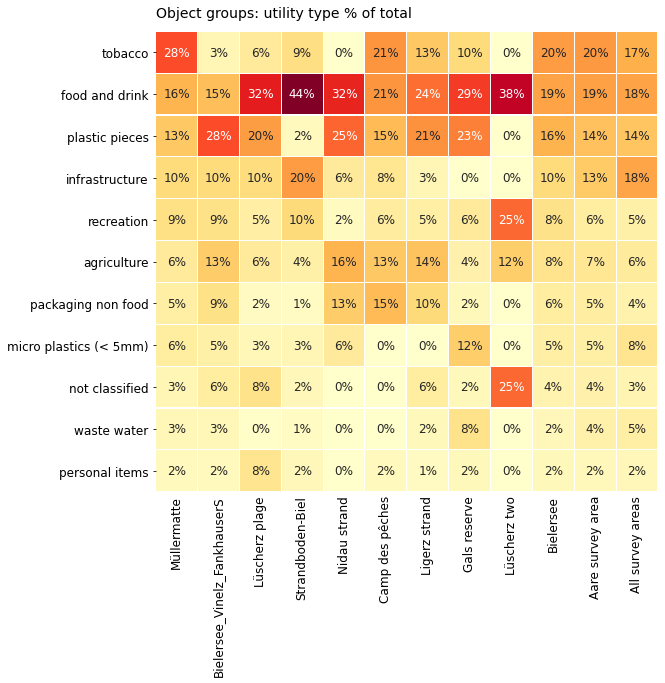

In [32]:
# divide each column by the column denominators
cgroup_p_t = code_groups_pcs_m.divide(column_denominators).round(3)
cgroup_p_t.rename(columns={x:location_wname_key.loc[x] for x in feature_names}, inplace=True)

fig = plt.figure(figsize=(9,9))

gs = GridSpec(12, 1, figure=fig, wspace=.5, hspace=.5, top=.9, width_ratios=[1])

axone = fig.add_subplot(gs[:,:])
sns.heatmap(cgroup_p_t , ax=axone, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12}, cbar=False, linewidth=.1, fmt='.0%', square=True, linecolor='white')
axone.set_title("Object groups: utility type % of total", **ck.title_k14)
axone.tick_params(**ck.no_xticks)
axone.set_ylabel("")

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=12)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=12)
plt.show()

### More information

Contact hammerdirt.ch for any questions about the content of this report. If you would like a report for your municipality contact the Swiss federal office for the environment: Municipal waste section.

In [33]:
author = "roger@hammerdirt.ch"
my_message = "Statistics is fun when you do it outside"
md(F"""### <span style="color:#000099">Have a great day</span>
**This project was made possible by the Swiss federal office for the environment.**<br>
This document originates from https://github.com/hammerdirt-analyst/iqals all copyrights apply.<br>
*{author}* pushed the run button on {today}.
""")

### <span style="color:#000099">Have a great day</span>
**This project was made possible by the Swiss federal office for the environment.**<br>
This document originates from https://github.com/hammerdirt-analyst/iqals all copyrights apply.<br>
*roger@hammerdirt.ch* pushed the run button on 2021-05-22.


[top](#top)<a id="annex"></a>
### Annex

1. [Effective data](#data)
2. [Populaion profile](#popinf)
3. [Survey location GPS](#gps)
4. [Inventory of all objects removed](#inventory)


##### <span id="data" style="color:#008891">Effective data</span>

The data is submitted in two parts. If a survey is missing either part we check the paper records and update when possible.

In [34]:
if len(no_qty) > 0:
    a_new_string = ', '.join([str(x) for x in no_qty.loc_date.unique()])    
    no_surveys = F"These dimensional records have been dropped, there is no matching survey data:\n\n{a_new_string}.\n"
else:
    no_surveys = "\nAll dimensional records found a home in the survey data!"

if len(no_matching_dim_records) > 0:
    no_dims = ', '.join([str(x) for x in no_dim_locdate])
    no_dimensions = F"\n<span style='color:#008891'>These are the surveys that do not have matching dimensional data</span>:\n\n{no_dims}\n"
    per_cent_surveys = F"\n! THE DIMENSIONAL DATA SUMMARY IS CALCULATED USING {np.round(((1-len(no_dim_locdate)/len(ldu))*100),1)}% of the survey data !"
    requests = "\nRequests have been made to surveyors to submit the missing records.\n"
    dimensional_data = F"{no_dimensions}{per_cent_surveys}{no_surveys}{requests}"
else:
    has_dimensions = "All the surveys found a home in the dimensional data"
    dimensional_data = F"""{has_dimensions}<br>{no_surveys}
"""

md(dimensional_data)

All the surveys found a home in the dimensional data<br>These dimensional records have been dropped, there is no matching survey data:

('luscherz-plage', '2021-01-26').



<a id="popinf"></a>

**Population profile**

The samples come from a variety of locations. Certain locations were sampled at monthly intervals others through out the year.

In [35]:
hmm = fd[(fd.quantity > 0)].copy()

pop_city_map = hmm[[levels[feature_component], 'population']].drop_duplicates()
pop_city_map = pop_city_map.set_index(levels[feature_component])

rb_dt_pop_count = hmm.groupby([levels[feature_component], 'population'], as_index=False).loc_date.nunique()
rb_dt_pop_count['population'] = rb_dt_pop_count.population.astype('int')

rb_dt_pop_count.rename(columns={'loc_date':'Number of samples'}, inplace=True)
rb_dt_pop_count.sort_values(by='population', inplace=True)

order = hmm[['population', levels[feature_component]]].drop_duplicates()
order = order.sort_values(by='population')
order = list(order[levels[feature_component]])

rb_dt = hmm.groupby(['loc_date','location','water_name_slug', 'date', 'city', 'population', 'buildings', 'streets'], as_index=False).pcs_m.sum()
rb_dt['population'] = rb_dt.population.astype('int')
rb_dt_pop = rb_dt.groupby(['population', levels[feature_component]], as_index=False).pcs_m.median()

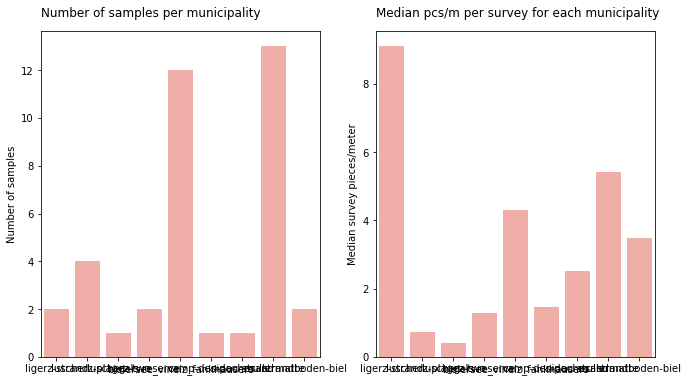

In [36]:
fig, ax = plt.subplots(1,2, figsize=(11,6))

# plot the number of surveys per population
sns.barplot(data=rb_dt_pop_count, x=levels[feature_component], y='Number of samples',color='salmon',alpha=.7, ax=ax[0])

ax[0].tick_params(**ck.rotate_0)
ticks = [i for i, n in enumerate(order)]
lables = order
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(lables, ha='center')

ax[0].set_title("Number of samples per municipality", **ck.title_k)
ax[0].set_xlabel('')

# plot the median pcs/m per survey
sns.barplot(data=rb_dt_pop, x=levels[feature_component], y='pcs_m', color='salmon', alpha=.7, ax=ax[1])
ax[1].tick_params(**ck.rotate_0)
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(lables, ha='center')
ax[1].set_title("Median pcs/m per survey for each municipality", **ck.title_k)
ax[1].set_xlabel('')
ax[1].set_ylabel('Median survey pieces/meter')


plt.show()
plt.close()

In [37]:
to_geo_data_dt = fd.groupby(['loc_date', levels[feature_component],'city','river_bassin'], as_index=False).pcs_m.sum()
tg_data_dt = to_geo_data_dt.groupby(levels[feature_component]).pcs_m.median()

to_geo_data_tndt = fd[fd.code.isin(a_combined_t_ten)].groupby(['loc_date', levels[feature_component],'city','river_bassin'], as_index=False).pcs_m.sum()
tg_data_dttn = to_geo_data_tndt.groupby(levels[feature_component]).pcs_m.median()

tg_beaches = dfBeaches[dfBeaches.index.isin(fd_locs)].copy()
tg_beaches['pcs_m'] = tg_beaches.index.map(lambda x: tg_data_dt[x])
tg_beaches['t_pcs_m'] = tg_beaches.index.map(lambda x: tg_data_dttn[x])
tg_beaches.to_csv(F"{project_directory}/bassin_summary_beaches.csv", index=False)

In [40]:
a_group = "tobacco"
a_type = 'groupname'

# this column get ranked
the_exp_column = 'population'

# name the ranking column
the_exp = 'pop_rank'

the_y = 'pcs_m'

d_a_data = a_data[a_data.water_name_slug.isin(['neuenburgersee', 'bielersee', 'thunersee', 'brienzersee'])&(a_data.quantity > 0)].copy()
d_a_data['urbanization'] = ((d_a_data.population + d_a_data.streets + d_a_data.buildings)/(d_a_data.population.sum() + d_a_data.streets.sum() + d_a_data.buildings.sum())).round(3)

a_list = d_a_data[the_exp_column].unique()
array = a_list
temp = array.argsort()
ranks = np.empty_like(temp)
ranks[temp] = np.arange(len(array))
d_a_data_ranks_map = {x:ranks[i]+1 for i,x in enumerate(a_list)}

d_a_data[the_exp] = d_a_data[the_exp_column].map(lambda x: d_a_data_ranks_map[x])

ranking_table = d_a_data[[the_exp_column, the_exp]].drop_duplicates()

ranking_table.sort_values(by='population', inplace=True)
ranking_table = ranking_table.astype('int')

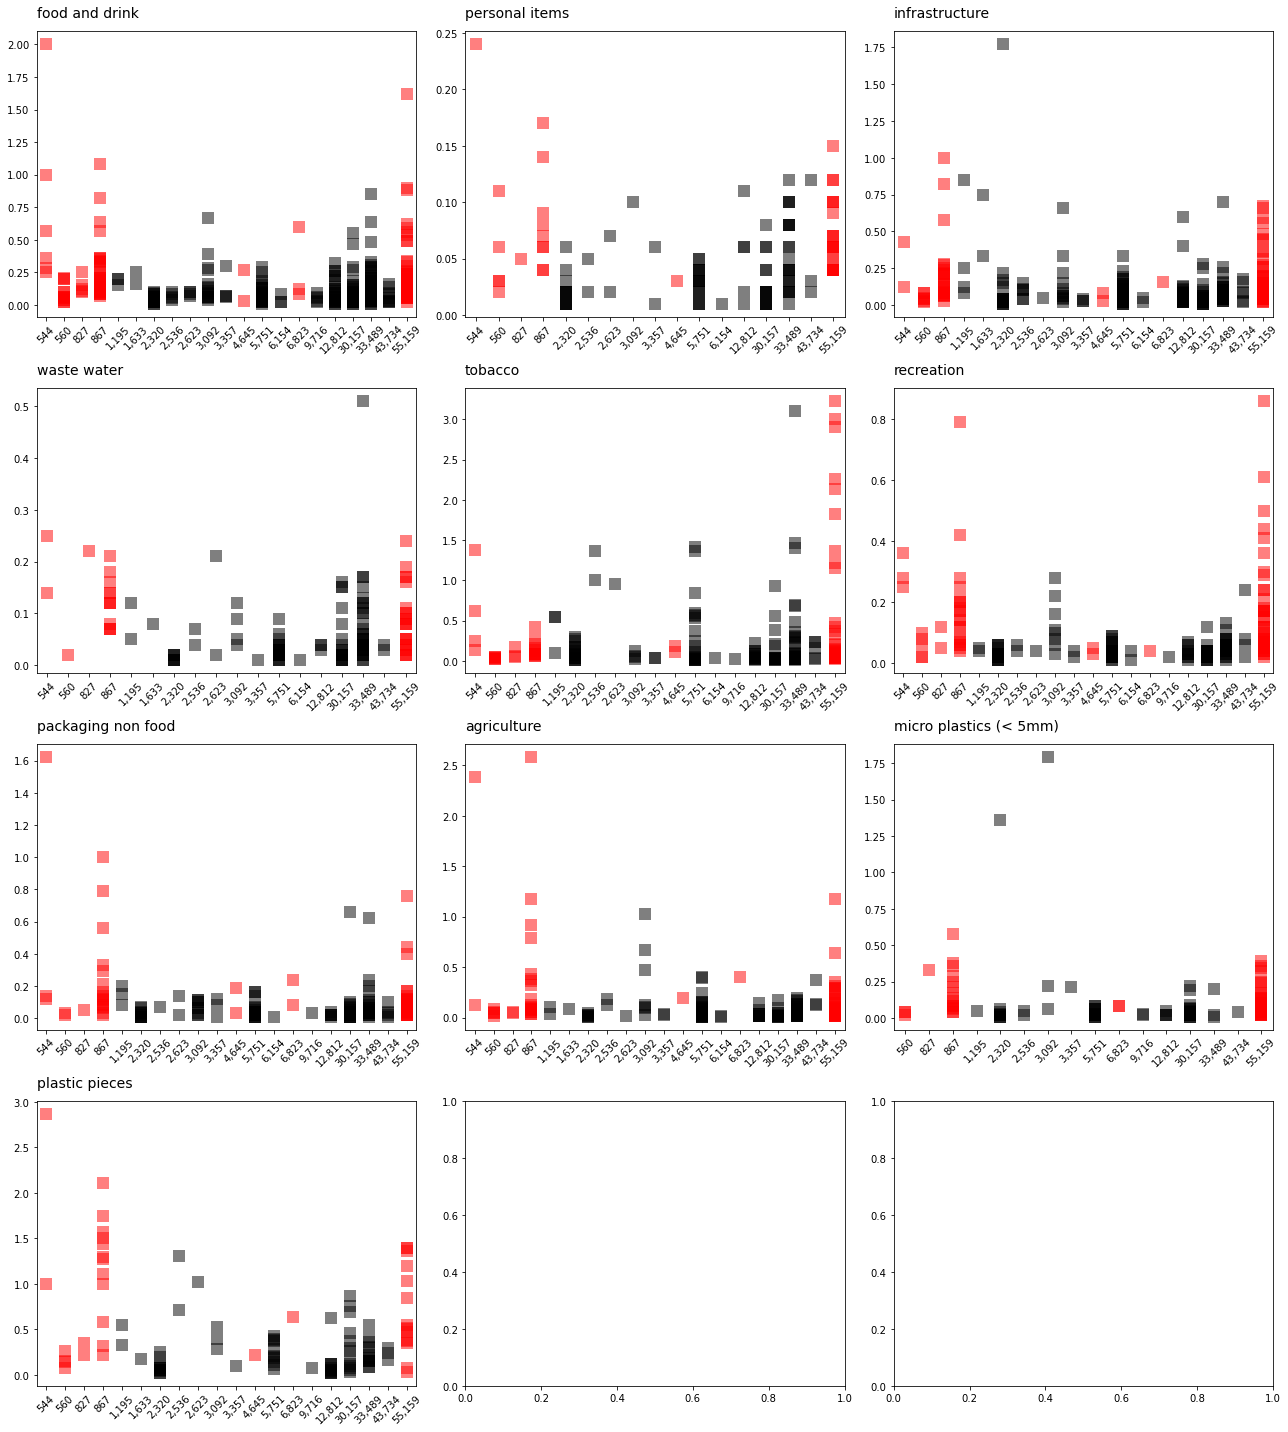

In [43]:
rows = 4
columns = 3

fig, ax = plt.subplots(rows, columns, figsize=(18,20))
the_group_names = list(d_a_data.groupname.unique())
the_group_names.remove('not classified')


background = [x for x in d_a_data[feature_level].unique() if x != levels[feature_level]]
palette = {x:'black' for x in background}
palette.update({levels[feature_level]:'red'})

for i,a_group in enumerate(the_group_names):   
    
    feature_top = d_a_data[(d_a_data[a_type] == a_group)].groupby(['loc_date',feature_level, the_exp,the_exp_column, the_y], as_index=False).pcs_m.sum()
       
    
    column = i%3
    row = math.floor((i)/3)
    
    sns.stripplot(data=feature_top, x=the_exp_column, y=the_y, ax=ax[(row,column)], alpha=0.5, marker="s", size=12, hue=feature_level, palette=palette,  jitter=False)
    
    labels = ax[(row, column)].get_xticklabels()
    ax[(row, column)].set_xticklabels(['{:,}'.format(int(float(x.get_text()))) for x in labels])
    ax[(row, column)].tick_params(**ck.rotate_45)
    
    ax[(row, column)].set_title(a_group, **ck.title_k14)
    
    ax[(row, column)].get_legend().remove()
    ax[(row, column)].set_xlabel("")
    ax[(row, column)].set_ylabel("")


plt.tight_layout()

plt.subplots_adjust(hspace=0.25)

plt.show()

In [42]:
import arviz as az
import pymc3 as pm
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from scipy import stats
from statsmodels import graphics

AttributeError: 'DataFrame' object has no attribute 'population'

In [ ]:
with pm.Model() as model_g:
    urb = pm.Beta
    
    alpha = pm.HalfNormal('alpha', sigma=1/d_var)
    mu = pm.HalfNormal('beta', sigma=d_var)

    pcs_pred = pm.NegativeBinomial("pcs_pred", alpha=alpha, mu=mu, observed=d.pcs_m)
    
    n_draws, n_chains = 1000, 3

    trace_g = pm.sample(draws=n_draws, chains=n_chains, tune=n_draws)
    ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model, size=1)

In [ ]:
az.plot_trace(trace_g)

In [ ]:
np.exp(az.summary(trace_g))

In [ ]:
az.plot_posterior(trace_g)

In [ ]:
fig, ax = plt.subplots()

sns.histplot(np.exp(ppc['y'].flatten()), stat='probability', ax=ax)
sns.histplot(d.pcs_m, ax=ax,stat='probability', color='red')

plt.show()

In [ ]:


gamma_model = sm.GLM(d.pcs_m, d[exog], family=sm.families.Gamma(sm.families.links.log()))

res = gamma_model.fit()

In [ ]:
print(res.summary())

In [ ]:
y = d.pcs_m/d.pcs_m.sum()
yhat = res.mu

fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

In [ ]:
fig, ax = plt.subplots()

ax.scatter(yhat, res.resid_pearson)
ax.hlines(0, 0, 1)
ax.set_xlim(0, 1)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

In [ ]:
fig, ax = plt.subplots()

resid = res.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals')

In [ ]:

graphics.gofplots.qqplot(resid, line='r')

#### <a id="popinf"></a>
**The median pieces per meter per survey of the most abundant objects by municipality**

In [ ]:
fig, ax = plt.subplots(figsize=(9,9))
axone=ax
sns.stripplot(data=hmm, x='urbanization', y='pcs_m', hue='code', dodge=False, palette='tab20', ax=axone)
sns.boxplot(data=hmm, x='urbanization', y='pcs_m', ax=axone)
axone.set_title("Median pieces per meter of the most abundant objects",**ck.title_k14)

axone.set_xlabel('')
axone.set_ylabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
g = sns.PairGrid(hmm[['pcs_m', 'urbanization']])
g.map(sns.scatterplot)

[Annex](#annex)<a id='gps'></a>

**Survey locations:**

In [ ]:
rb_beaches_list = dfBeaches[dfBeaches.index.isin(fd_locs)][['location', 'latitude', 'longitude', 'city', 'water_name']].copy()
rb_beaches_list.set_index('location', inplace=True, drop=True)
rb_beaches_list.sort_values(by='water_name')

[Annex](#annex)<a id="inventory" ></a>
#### Inventory of all items

In [ ]:
fd_code_t['utility'] = fd_code_t.index.map(lambda x: utility_map.loc[x, 'groupname'])
fd_code_t['item'] = fd_code_t.index.map(lambda x: code_description_map.loc[x])
fd_code_t["% of total"] = (fd_code_t["% of total"]*100).round(1)
complete_inventory = fd_code_t[['item', 'quantity', '% of total', 'utility']]

In [ ]:
pd.set_option('display.max_rows', None)
complete_inventory[complete_inventory.quantity > 0].sort_values(by='quantity', ascending=False)